In [1]:
import pandas as pd

# twitter finance news corpus, kaggle link: https://www.kaggle.com/datasets/sulphatet/twitter-financial-news
twitter_fnews_train_df = pd.read_csv("sent_train.csv")
twitter_fnews_test_df = pd.read_csv("sent_valid.csv")

In [2]:
yelp_train_df = pd.read_csv("yelp_train.csv")
yelp_test_df = pd.read_csv("yelp_test.csv")

In [2]:
import re
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def process_text(text):
    """
    This removes User name, url, Punctations, number, space
    """
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r' www\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'[^\w\s]|[\d]', ' ', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = ''.join(ch for ch in text if ch not in string.punctuation)
    text = text.strip().lower().encode('ascii', 'ignore').decode()
    text = remove_stopwords(text)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
twitter_fnews_train_df['text'] = twitter_fnews_train_df['text'].apply(process_text)
twitter_fnews_test_df['text'] = twitter_fnews_test_df['text'].apply(process_text)

#### Save to jsonline file

In [4]:
import json

def save_df_to_jsonl(df, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for index, row in df.iterrows():
            data = {'text': row['text'], 'label': row['label']}
            json_line = json.dumps(data, ensure_ascii=False)
            f.write(json_line + '\n')

#### Twitter finance news corpus

In [5]:
save_df_to_jsonl(twitter_fnews_train_df, "twitter_news_train.jsonl")
save_df_to_jsonl(twitter_fnews_test_df, "twitter_news_test.jsonl")

#### Yelp dataset

In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00


In [7]:
from datasets import load_dataset

# The huggingface link: https://huggingface.co/datasets/yelp_review_full
dataset = load_dataset("yelp_review_full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [9]:
import pandas as pd
train_dataset = dataset['train'].select(range(int(20000)))
test_dataset = dataset['test'].select(range(int(5000)))

# convert to DataFrame
yelp_train_df = pd.DataFrame(train_dataset)
yelp_test_df = pd.DataFrame(test_dataset)

train_csv_file = 'yelp_train.csv'
test_csv_file = 'yelp_test.csv'

yelp_train_df.to_csv(train_csv_file, index=False)
yelp_test_df.to_csv(test_csv_file, index=False)

In [11]:
save_df_to_jsonl(yelp_train_df, "yelp_train.jsonl")
save_df_to_jsonl(yelp_test_df, "yelp_test.jsonl")

#### Word cloud of twitter finance news and Yelp

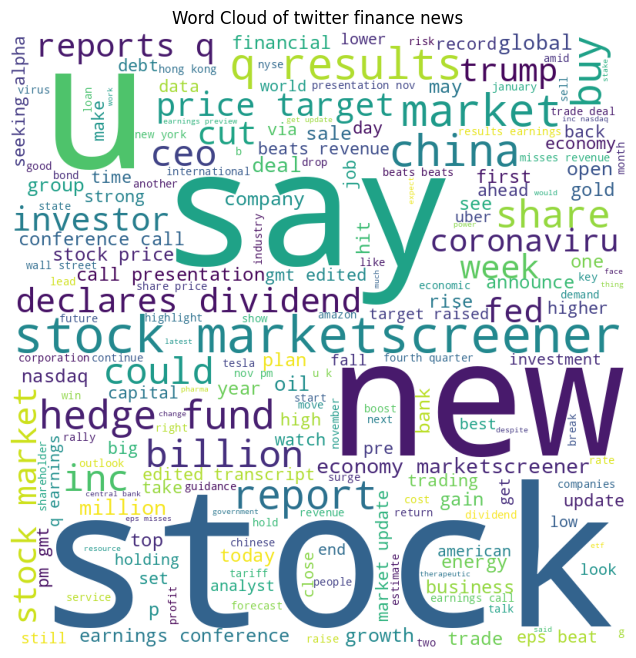

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


# Generate word cloud from twitter finance news text
generate_word_cloud(' '.join(twitter_fnews_train_df['text']), 'Word Cloud of twitter finance news')

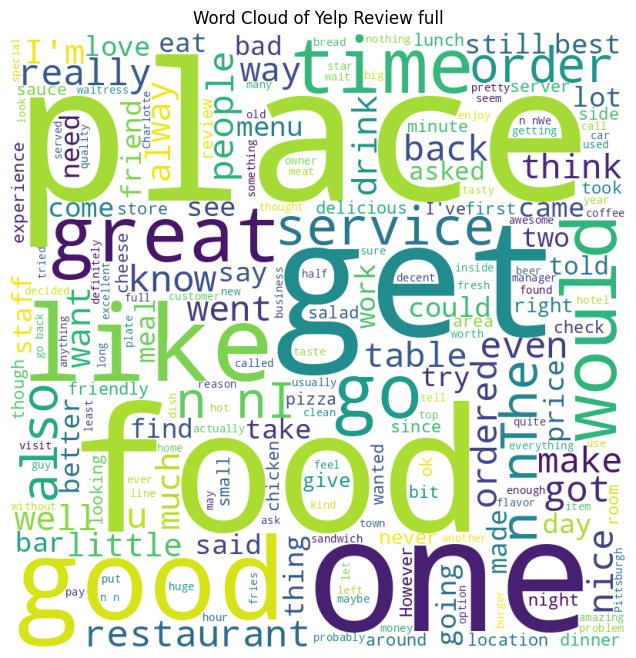

In [22]:
# Generate word cloud from Yelp text
generate_word_cloud(' '.join(yelp_train_df['text']), 'Word Cloud of Yelp Review full')

#### Using Traditional TF-IDF embedding and machine learning based sentiment analysis methods

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def tf_idf_embedding(train_df, test_df):
  # Initialize TF-IDF vectorizer
  tfidf_vectorizer = TfidfVectorizer()

  # TF-IDF vectorization of the training set
  X_train = tfidf_vectorizer.fit_transform(train_df['text'])

  # TF-IDF vectorization of the testing set
  X_test = tfidf_vectorizer.transform(test_df['text'])

  return X_train, X_test

def nb_pred(train_df, test_df, X_train, X_test):
  y_train = train_df['label']
  y_test = test_df['label']
  # Initialize Naive Bayes classifier
  nb_classifier = MultinomialNB()

  # Train the Naive Bayes classifier
  nb_classifier.fit(X_train, y_train)

  # Predictions using Naive Bayes classifier
  nb_predictions = nb_classifier.predict(X_test)

  # Print classification report for Naive Bayes
  print("Classification Report for Naive Bayes:")
  print(classification_report(y_test, nb_predictions))

def rf_pred(train_df, test_df, X_train, X_test):
  y_train = train_df['label']
  y_test = test_df['label']
  # Initialize Random Forest classifier
  rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

  # Train the Random Forest classifier
  rf_classifier.fit(X_train, y_train)

  # Predictions using Random Forest classifier
  rf_predictions = rf_classifier.predict(X_test)

  # Print classification report for Random Forest
  print("Classification Report for Random Forest:")
  print(classification_report(y_test, rf_predictions))


In [25]:
X_train, X_test = tf_idf_embedding(twitter_fnews_train_df, twitter_fnews_test_df)
nb_pred(twitter_fnews_train_df, twitter_fnews_test_df, X_train, X_test)

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.90      0.08      0.14       347
           1       0.76      0.29      0.42       475
           2       0.71      0.99      0.83      1566

    accuracy                           0.72      2388
   macro avg       0.79      0.45      0.46      2388
weighted avg       0.75      0.72      0.65      2388



In [26]:
rf_pred(twitter_fnews_train_df, twitter_fnews_test_df, X_train, X_test)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.43      0.56       347
           1       0.75      0.61      0.67       475
           2       0.82      0.95      0.88      1566

    accuracy                           0.81      2388
   macro avg       0.78      0.66      0.70      2388
weighted avg       0.80      0.81      0.79      2388



In [27]:
X_train, X_test = tf_idf_embedding(yelp_train_df, yelp_test_df)
nb_pred(yelp_train_df, yelp_test_df, X_train, X_test)

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1141
           1       0.39      0.49      0.44      1009
           2       0.33      0.71      0.45      1003
           3       0.40      0.21      0.27       986
           4       0.82      0.08      0.15       861

    accuracy                           0.42      5000
   macro avg       0.51      0.41      0.38      5000
weighted avg       0.51      0.42      0.39      5000



In [28]:
rf_pred(yelp_train_df, yelp_test_df, X_train, X_test)

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.59      0.74      0.65      1141
           1       0.40      0.35      0.38      1009
           2       0.39      0.47      0.42      1003
           3       0.43      0.34      0.38       986
           4       0.60      0.48      0.53       861

    accuracy                           0.48      5000
   macro avg       0.48      0.48      0.47      5000
weighted avg       0.48      0.48      0.48      5000



#### My Deep learning model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
from torch.utils.data import Dataset

# Define Dataset for pytorch tensor
class TorchDataset(Dataset):
    def __init__(self, examples, tokenizer, bert_model):
        self.examples = examples
        self.tokenizer = tokenizer
        self.bert_model = bert_model

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        text = self.examples[idx]['text']
        label = self.examples[idx]['label']

        # Encode text using the BERT tokenizer
        encoding = self.tokenizer(text, return_tensors='pt', max_length=256, pad_to_max_length=True, truncation=True)

        with torch.no_grad():
            output = self.bert_model(**encoding)

        text_embedding = output.last_hidden_state
        text_embedding = text_embedding.view(text_embedding.shape[1], text_embedding.shape[2])

        return text_embedding, label


#### Plot the loss curve and accuracy curve

In [5]:
def plot_loss(avg_train_loss_list, avg_val_loss_list, save_name):
    plt.figure(figsize=(12, 6))

    # loss curve
    plt.plot(avg_train_loss_list, label='Train Loss', color='blue')
    plt.plot(avg_val_loss_list, label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss of Ours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_name, dpi=1200)
    plt.show()

def plot_accuracy(train_accuracy_list, val_accuracy_list, save_name):
    # accuracy curve
    plt.figure(figsize=(12, 6))

    plt.plot(train_accuracy_list, label='Train Accuracy', color='green')
    plt.plot(val_accuracy_list, label='Validation Accuracy', color='red')

    plt.title('Training and Validation Accuracy of Ours')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_name, dpi=1200)
    plt.show()

In [6]:
import torch.nn.functional as F

class MultiLayerCNN(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1):
        super(MultiLayerCNN, self).__init__()
        self.input_channels = input_channels
        self.conv1d = nn.Conv1d(in_channels=input_channels,
                                out_channels=output_channels,
                                kernel_size=kernel_size,
                                stride=stride)

        # Global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1d(x.permute(0, 2, 1))  # permute to match input format
        x = self.relu(x)
        x = self.global_avg_pooling(x).squeeze(dim=2)  # Global average pooling
        return x


# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:

        output, _ = self.lstm(inputs)

        return output[:, -1, :]


class EnsembleModelWithBert(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lstm_num_classes):
        super(EnsembleModelWithBert, self).__init__()

        # Create instances of MultiLayerCNN and LSTMClassifier
        self.cnn_model = MultiLayerCNN(input_size, input_size)
        self.lstm_model = LSTMClassifier(input_size, hidden_size, num_layers)

        # Fully connected layer for ensemble
        self.fc = nn.Linear(input_size + hidden_size, lstm_num_classes)


    def forward(self, inputs):
        # Forward pass through the CNN model
        cnn_output = self.cnn_model(inputs)

        # Forward pass through the LSTM model
        lstm_output = self.lstm_model(inputs)
        # print(f"{cnn_output.shape=}, {lstm_output.shape=}")

        # Concatenate the outputs from CNN and LSTM
        concatenated_output = torch.cat([cnn_output, lstm_output], dim=1)

        # Fully connected layer for ensemble
        output = F.softmax(self.fc(concatenated_output), dim=1)

        return output

    def loss(self, output, labels):
        # Calculate cross-entropy loss
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(output, labels)
        return loss

    def pred(self, output):
        _, predicted = torch.max(output.data, 1)
        return predicted

    def accuracy(self, output, labels) -> torch.Tensor:
        predicted = self.pred(output)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()

        accuracy = correct / total

        return accuracy, predicted

In [7]:
from sklearn.metrics import classification_report

def train(model, num_epochs, y_test):
    # Train the model
    avg_train_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    avg_val_loss_list = []


    for epoch in range(num_epochs):
        # Total loss across train data
        train_loss = 0.0
        # Total number of correctly predicted training labels
        train_correct = 0
        # Total number of training sequences processed
        train_seqs = 0

        print(f"Epoch {epoch}/{num_epochs}")
        tqdm_train_loader = tqdm(train_loader, leave=False)

        model.train()
        for batch_idx, (sentences_batch, labels_batch) in enumerate(
            tqdm_train_loader
        ):
            sentences_batch, labels_batch = (
                sentences_batch.to(device),
                labels_batch.to(device),
            )

            # Make predictions
            logits = model(sentences_batch)

            # Compute loss and number of correct predictions
            bats = len(logits)
            # print(f"{logits.shape=}, {labels_batch.shape=}")
            loss = model.loss(logits, labels_batch)
            accuracy, predicted = model.accuracy(logits, labels_batch)
            correct = accuracy * bats

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics and update status
            train_loss += loss.item()
            train_correct += correct
            train_seqs += len(sentences_batch)
            tqdm_train_loader.set_description_str(
                f"[Loss]: {train_loss / (batch_idx + 1):.4f} [Acc]: {train_correct / train_seqs:.4f}"
            )
        tqdm_train_loader.close()
        print()

        avg_train_loss = train_loss / len(tqdm_train_loader)
        train_accuracy = train_correct / train_seqs
        print(
            f"\t[Training Loss]: {avg_train_loss:.4f} [Training Accuracy]: {train_accuracy:.4f}"
        )
        avg_train_loss_list.append(avg_train_loss)
        train_accuracy_list.append(train_accuracy)

        # Total loss across validation data
        val_loss = 0.0
        # Total number of correctly predicted validation labels
        val_correct = 0
        # Total number of validation sequences processed
        val_seqs = 0

        tqdm_val_loader = tqdm(val_loader, leave=False)

        model.eval()
        predict_list = []
        for batch_idx, (sentences_batch, labels_batch) in enumerate(
            tqdm_val_loader
        ):
            sentences_batch, labels_batch = (
                sentences_batch.to(device),
                labels_batch.to(device),
            )

            with torch.no_grad():
                # Make predictions
                logits = model(sentences_batch)

                bats = len(logits)
                # Compute loss and number of correct predictions and accumulate metrics and update status
                val_loss += model.loss(logits, labels_batch).item()
                accuracy, predicted = model.accuracy(logits, labels_batch)
                val_correct += accuracy * bats
                val_seqs += len(sentences_batch)
                tqdm_val_loader.set_description_str(
                    f"[Loss]: {val_loss / (batch_idx + 1):.4f} [Acc]: {val_correct / val_seqs:.4f}"
                )
                predict_list.extend(predicted.cpu().detach().numpy().tolist())
        tqdm_val_loader.close()
        print()

        avg_val_loss = val_loss / len(tqdm_val_loader)
        val_accuracy = val_correct / val_seqs
        print(
            f"\t[Validation Loss]: {avg_val_loss:.4f} [Validation Accuracy]: {val_accuracy:.4f}"
        )
        avg_val_loss_list.append(avg_val_loss)
        val_accuracy_list.append(val_accuracy)

        print(classification_report(y_test, predict_list))


    return avg_train_loss_list, train_accuracy_list, val_accuracy_list, avg_val_loss_list

#### Load Twitter finance news dataset, train and evaluate

In [ ]:
from datasets import Dataset, DatasetDict
from tqdm import tqdm

path_dict = {"train": 'twitter_news_train.jsonl',
              "test": "twitter_news_test.jsonl"}

dataset = DatasetDict.from_json(path_or_paths=path_dict)

from torch.utils.data import DataLoader

train_dataset = TorchDataset(dataset['train'], tokenizer, bert_model)
val_dataset = TorchDataset(dataset['test'], tokenizer, bert_model)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Hyper-parameters
hidden_size = 128  # Hidden layer feature dimension
num_layers = 2  # Number of LSTM layers
num_classes = 3  # Number of classification categories
input_size = bert_model.config.hidden_size

model = EnsembleModelWithBert(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

avg_train_loss_list, train_accuracy_list, val_accuracy_list, avg_val_loss_list = train(model, num_epochs=5, y_test=twitter_fnews_test_df['label'])

Epoch 0/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.9147 [Training Accuracy]: 0.6450


C:\anoconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anoconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anoconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



	[Validation Loss]: 0.8915 [Validation Accuracy]: 0.6558
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       347
           1       0.00      0.00      0.00       475
           2       0.66      1.00      0.79      1566

    accuracy                           0.66      2388
   macro avg       0.22      0.33      0.26      2388
weighted avg       0.43      0.66      0.52      2388

Epoch 1/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8768 [Training Accuracy]: 0.6666



	[Validation Loss]: 0.8341 [Validation Accuracy]: 0.7131
              precision    recall  f1-score   support

           0       0.62      0.10      0.18       347
           1       0.57      0.40      0.47       475
           2       0.74      0.94      0.83      1566

    accuracy                           0.71      2388
   macro avg       0.64      0.48      0.49      2388
weighted avg       0.69      0.71      0.66      2388

Epoch 2/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8333 [Training Accuracy]: 0.7128



	[Validation Loss]: 0.8144 [Validation Accuracy]: 0.7307
              precision    recall  f1-score   support

           0       0.58      0.34      0.43       347
           1       0.77      0.27      0.40       475
           2       0.74      0.96      0.84      1566

    accuracy                           0.73      2388
   macro avg       0.70      0.52      0.55      2388
weighted avg       0.72      0.73      0.69      2388

Epoch 3/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8132 [Training Accuracy]: 0.7345



	[Validation Loss]: 0.8066 [Validation Accuracy]: 0.7416
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       347
           1       0.62      0.49      0.54       475
           2       0.79      0.89      0.84      1566

    accuracy                           0.74      2388
   macro avg       0.66      0.60      0.62      2388
weighted avg       0.73      0.74      0.73      2388

Epoch 4/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8013 [Training Accuracy]: 0.7461



	[Validation Loss]: 0.8056 [Validation Accuracy]: 0.7404
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       347
           1       0.55      0.57      0.56       475
           2       0.81      0.87      0.84      1566

    accuracy                           0.74      2388
   macro avg       0.66      0.61      0.62      2388
weighted avg       0.73      0.74      0.73      2388



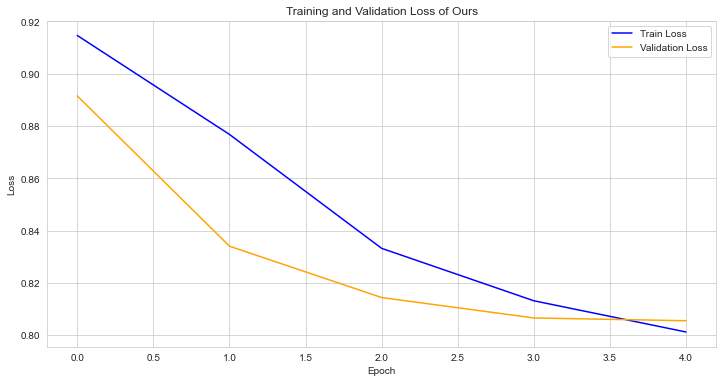

In [18]:
plot_loss(avg_train_loss_list, avg_val_loss_list, save_name='twitter_news_loss.jpg')

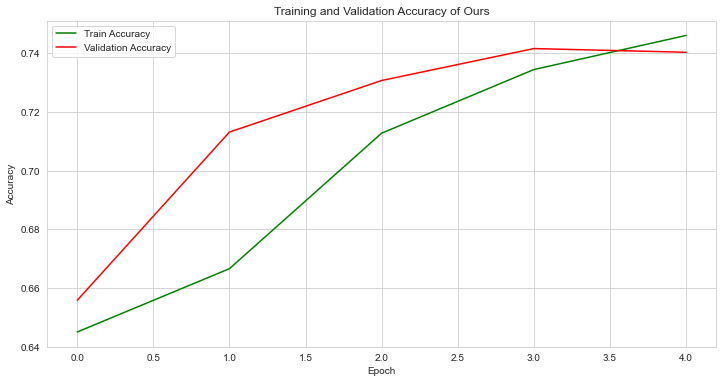

In [19]:
plot_accuracy(train_accuracy_list, val_accuracy_list, save_name='twitter_news_acc.jpg')

In [14]:
hidden_size = 64  # hidden size

model = EnsembleModelWithBert(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

avg_train_loss_list, train_accuracy_list, val_accuracy_list, avg_val_loss_list = train(model, num_epochs=5, y_test=twitter_fnews_test_df['label'])

Epoch 0/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.9127 [Training Accuracy]: 0.6447


C:\anoconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anoconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anoconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



	[Validation Loss]: 0.8844 [Validation Accuracy]: 0.6558
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       347
           1       0.00      0.00      0.00       475
           2       0.66      1.00      0.79      1566

    accuracy                           0.66      2388
   macro avg       0.22      0.33      0.26      2388
weighted avg       0.43      0.66      0.52      2388

Epoch 1/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8616 [Training Accuracy]: 0.6801



	[Validation Loss]: 0.8245 [Validation Accuracy]: 0.7278
              precision    recall  f1-score   support

           0       0.58      0.28      0.37       347
           1       0.64      0.35      0.45       475
           2       0.75      0.94      0.84      1566

    accuracy                           0.73      2388
   macro avg       0.66      0.52      0.55      2388
weighted avg       0.70      0.73      0.69      2388

Epoch 2/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8299 [Training Accuracy]: 0.7168



	[Validation Loss]: 0.8081 [Validation Accuracy]: 0.7425
              precision    recall  f1-score   support

           0       0.63      0.32      0.42       347
           1       0.73      0.36      0.48       475
           2       0.75      0.95      0.84      1566

    accuracy                           0.74      2388
   macro avg       0.70      0.54      0.58      2388
weighted avg       0.73      0.74      0.71      2388

Epoch 3/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8137 [Training Accuracy]: 0.7324



	[Validation Loss]: 0.8024 [Validation Accuracy]: 0.7437
              precision    recall  f1-score   support

           0       0.59      0.38      0.46       347
           1       0.66      0.43      0.52       475
           2       0.78      0.92      0.84      1566

    accuracy                           0.74      2388
   macro avg       0.68      0.58      0.61      2388
weighted avg       0.73      0.74      0.72      2388

Epoch 4/5


  0%|          | 0/150 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 0.8031 [Training Accuracy]: 0.7457



	[Validation Loss]: 0.7998 [Validation Accuracy]: 0.7466
              precision    recall  f1-score   support

           0       0.64      0.37      0.46       347
           1       0.63      0.48      0.54       475
           2       0.78      0.91      0.84      1566

    accuracy                           0.75      2388
   macro avg       0.68      0.58      0.62      2388
weighted avg       0.73      0.75      0.73      2388



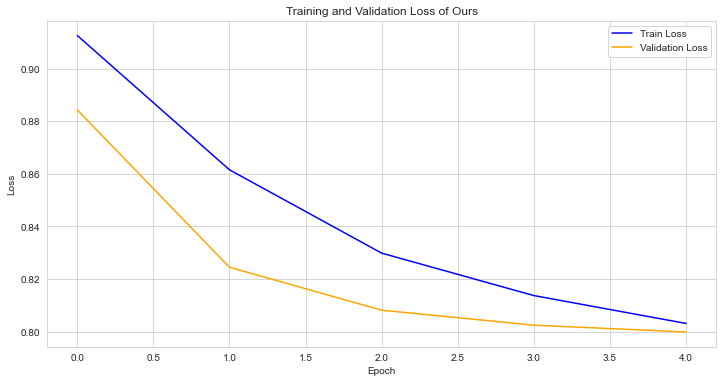

In [15]:
plot_loss(avg_train_loss_list, avg_val_loss_list, save_name='twitter_news_loss_hs_64.jpg')

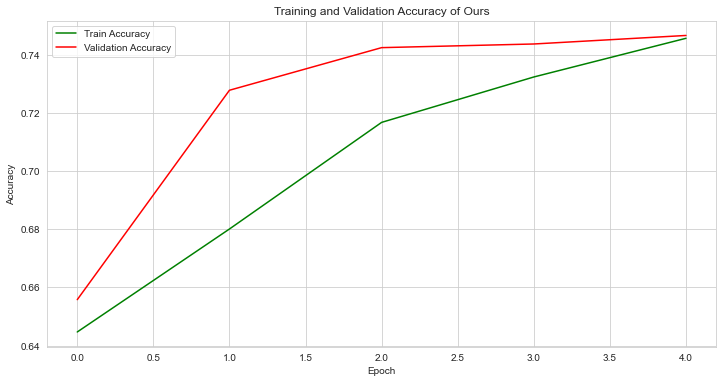

In [16]:
plot_accuracy(train_accuracy_list, val_accuracy_list, save_name='twitter_news_acc_hs_64.jpg')

#### Load Yelp dataset, train and evaluate

In [ ]:
from datasets import Dataset, DatasetDict
from tqdm import tqdm

path_dict = {"train": './yelp_train.jsonl',
              "test": "./yelp_test.jsonl"}

dataset = DatasetDict.from_json(path_or_paths=path_dict)

from torch.utils.data import DataLoader

train_dataset = TorchDataset(dataset['train'], tokenizer, bert_model)
val_dataset = TorchDataset(dataset['test'], tokenizer, bert_model)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Hyper-parameters
hidden_size = 128  # Hidden layer feature dimension
num_layers = 2  # Number of LSTM layers
num_classes = 5  # Number of classification categories
input_size = bert_model.config.hidden_size

model = EnsembleModelWithBert(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


avg_train_loss_list, train_accuracy_list, val_accuracy_list, avg_val_loss_list = train(model, num_epochs=5, y_test=yelp_test_df['label'])

Epoch 0/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.4561 [Training Accuracy]: 0.4517



	[Validation Loss]: 1.3830 [Validation Accuracy]: 0.5226
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      1141
           1       0.43      0.48      0.45      1009
           2       0.46      0.41      0.44      1003
           3       0.48      0.32      0.39       986
           4       0.58      0.62      0.60       861

    accuracy                           0.52      5000
   macro avg       0.51      0.52      0.51      5000
weighted avg       0.52      0.52      0.51      5000

Epoch 1/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3832 [Training Accuracy]: 0.5159



	[Validation Loss]: 1.3743 [Validation Accuracy]: 0.5254
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      1141
           1       0.46      0.38      0.41      1009
           2       0.43      0.53      0.47      1003
           3       0.49      0.18      0.27       986
           4       0.59      0.69      0.63       861

    accuracy                           0.53      5000
   macro avg       0.51      0.52      0.50      5000
weighted avg       0.51      0.53      0.50      5000

Epoch 2/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3677 [Training Accuracy]: 0.5324



	[Validation Loss]: 1.3555 [Validation Accuracy]: 0.5412
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1141
           1       0.48      0.38      0.43      1009
           2       0.45      0.45      0.45      1003
           3       0.46      0.49      0.47       986
           4       0.61      0.62      0.62       861

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.54      0.54      5000

Epoch 3/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3559 [Training Accuracy]: 0.5438



	[Validation Loss]: 1.3489 [Validation Accuracy]: 0.5474
              precision    recall  f1-score   support

           0       0.64      0.79      0.71      1141
           1       0.49      0.40      0.44      1009
           2       0.47      0.44      0.46      1003
           3       0.47      0.52      0.49       986
           4       0.66      0.55      0.60       861

    accuracy                           0.55      5000
   macro avg       0.55      0.54      0.54      5000
weighted avg       0.54      0.55      0.54      5000

Epoch 4/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3492 [Training Accuracy]: 0.5490



	[Validation Loss]: 1.3493 [Validation Accuracy]: 0.5410
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1141
           1       0.47      0.47      0.47      1009
           2       0.44      0.53      0.48      1003
           3       0.49      0.25      0.33       986
           4       0.58      0.71      0.63       861

    accuracy                           0.54      5000
   macro avg       0.53      0.54      0.53      5000
weighted avg       0.54      0.54      0.53      5000



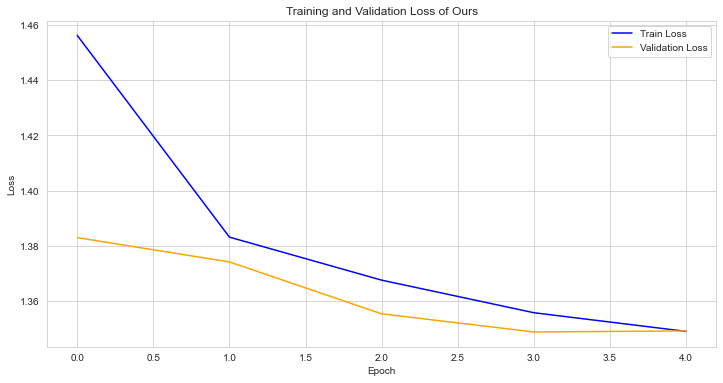

In [22]:
plot_loss(avg_train_loss_list, avg_val_loss_list, save_name='yelp_loss.jpg')

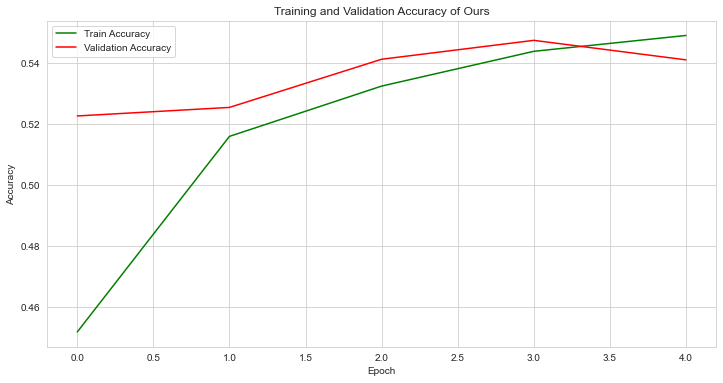

In [23]:
plot_accuracy(train_accuracy_list, val_accuracy_list, save_name='yelp_acc.jpg')

#### Hidden size setting to 256

In [24]:
hidden_size = 256   # hidden size

model = EnsembleModelWithBert(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

avg_train_loss_list, train_accuracy_list, val_accuracy_list, avg_val_loss_list = train(model, num_epochs=5, y_test=yelp_test_df['label'])

Epoch 0/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.4556 [Training Accuracy]: 0.4384



	[Validation Loss]: 1.3951 [Validation Accuracy]: 0.4922
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1141
           1       0.40      0.44      0.42      1009
           2       0.42      0.36      0.39      1003
           3       0.48      0.12      0.19       986
           4       0.54      0.69      0.61       861

    accuracy                           0.49      5000
   macro avg       0.48      0.49      0.45      5000
weighted avg       0.48      0.49      0.46      5000

Epoch 1/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3896 [Training Accuracy]: 0.5094



	[Validation Loss]: 1.3732 [Validation Accuracy]: 0.5182
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      1141
           1       0.40      0.48      0.44      1009
           2       0.46      0.33      0.38      1003
           3       0.48      0.34      0.40       986
           4       0.63      0.59      0.61       861

    accuracy                           0.52      5000
   macro avg       0.51      0.51      0.50      5000
weighted avg       0.51      0.52      0.51      5000

Epoch 2/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3698 [Training Accuracy]: 0.5293



	[Validation Loss]: 1.3589 [Validation Accuracy]: 0.5470
              precision    recall  f1-score   support

           0       0.66      0.76      0.71      1141
           1       0.47      0.46      0.47      1009
           2       0.47      0.42      0.44      1003
           3       0.47      0.46      0.47       986
           4       0.62      0.61      0.62       861

    accuracy                           0.55      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.55      0.54      5000

Epoch 3/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3589 [Training Accuracy]: 0.5414



	[Validation Loss]: 1.3605 [Validation Accuracy]: 0.5328
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1141
           1       0.46      0.45      0.46      1009
           2       0.42      0.61      0.50      1003
           3       0.47      0.40      0.43       986
           4       0.66      0.52      0.58       861

    accuracy                           0.53      5000
   macro avg       0.55      0.53      0.53      5000
weighted avg       0.55      0.53      0.53      5000

Epoch 4/5


  0%|          | 0/313 [00:00<?, ?it/s]C:\anoconda\lib\site-packages\transformers\tokenization_utils_base.py:2300: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



	[Training Loss]: 1.3517 [Training Accuracy]: 0.5480



	[Validation Loss]: 1.3466 [Validation Accuracy]: 0.5502
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1141
           1       0.49      0.39      0.44      1009
           2       0.46      0.50      0.48      1003
           3       0.48      0.38      0.42       986
           4       0.60      0.69      0.64       861

    accuracy                           0.55      5000
   macro avg       0.54      0.55      0.54      5000
weighted avg       0.54      0.55      0.54      5000



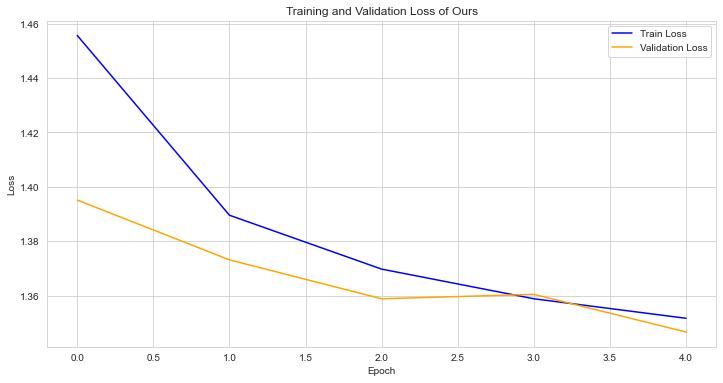

In [25]:
plot_loss(avg_train_loss_list, avg_val_loss_list, save_name='yelp_loss_hiddensize_256.jpg')

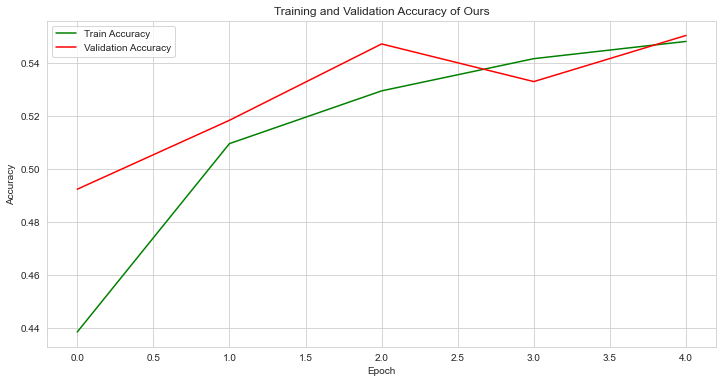

In [26]:
plot_accuracy(train_accuracy_list, val_accuracy_list, save_name='yelp_acc_hiddensize_256.jpg')